# Tuning the early stopping patience hyperparameter based on 5-fold cross-validation

The original version of this notebook was incorrect as it used early stopping based on the data that was being used for validation.

User c is completely removed as this is the test set.

The remaining users A,B,D,E and F make up each fold.

For example, fold 1 will train on users B,D,E and F then evaluate on A (and so on for each fold).
The training data is made up of 80% taken from the four subjects not being used for testing. The validation data the early stopping uses is the remaining 20% then the model is evaluated on the test subject.

Choice of model (8-16) justified from "7_CNN_model_comparison.ipynb"
Other hyperparameters chosen from notebook 8.

## Notebook setup

Allow editing of modules using editor (auto reloading)

In [1]:
# Needed to allow editing using PyCharm etc
%load_ext autoreload
%autoreload 2

The following cell is needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [2]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
#     !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/processed/doppler_spectrograms/3/'

HYPERPARAMETER_PATH = BASE_PATH + 'results/CNN_hyperparameter_search/'

RESULTS_PATH = BASE_PATH + 'results/CNN_early_stopping_tuning/'
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH) 

In [3]:
SAVE_RESULTS = False
SAVE_GRAPHS = True

Import remaining packages

In [ ]:
import numpy as np
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
# ! pip install scikit-optimize
from skopt import load

In [6]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup

In [7]:
target_names = ["walking", "pushing", "sitting", "pulling",
                "circling", "clapping", "bending"]
nb_classes = len(target_names)

# input image dimensions
img_rows, img_cols = 75, 75
# user c excluded as this is reserved for final evaluation
users = ["A", "B", "D", "E", "F"] 

In [11]:
def load_data(user_letter):
    with open(DATA_PATH + user_letter + "_data.pkl", 'rb') as data_file:
        data = pickle.load(data_file)
        data = data.reshape(data.shape[0], 1, 75, 75)
        
    with open(DATA_PATH + user_letter + "_labels.pkl", 'rb') as labels_file:
        labels = pickle.load(labels_file)
        labels = np.reshape(labels, (len(labels), 1))
     
    return data, labels

In [10]:
datasets = {}
for user in users:
    data, labels = load_data(user)
    datasets[user] = {"data":data, "labels":labels}

In [12]:
def split_train_validation_test(test_user, total_folds=5, validation_fold=0):
    '''
    split the data into:
        a test set composed of all data from test subject
        a train set composed of 80% (depending on total folds) of remaining subjects
        a validation set composed of the remaing 20%
    ''' 
    
    # split by user then action
    labels = np.arange(0, 7)
    actions = {}
    for user in users:
        actions[user] = {}
        for label in labels:
            actions[user][str(label)] = []
        
    for user in users:
        data = datasets[user]["data"]
        labels = datasets[user]["labels"]
        for index, label in enumerate(labels):
            actions[user][str(label[0])].append(data[index])
        
    # convert to numpy array
    labels = np.arange(0, 7)
    for user in users:
        for label in labels:
            actions[user][str(label)] = np.array(actions[user][str(label)])
            
    train_labels = []
    train_data = []
    validation_labels = []
    validation_data = []
    test_labels = []
    test_data = []
    # each user A->F
    for user in users:
        # 0 -> 6
        for label in labels:
            # number of data points for this user at this label
            length = actions[user][str(label)].shape[0]
            
            if user == test_user:
                testing_data = actions[user][str(label)]
                testing_labels = np.full(testing_data.shape[0], label)
                test_data.append(testing_data)
                test_labels.append(testing_labels)  
                
            else:
                # for example, if using 5 folds splits data into 5 subsets
                split_actions = np.array_split(actions[user][str(label)], total_folds)
                training_data = []
                validating_data = []
                for fold in range(total_folds):
                    if fold == validation_fold:
                        validating_data.append(split_actions[fold])
                    else:
                        training_data.append(split_actions[fold])

                training_data = np.concatenate(training_data, axis=0)
                training_labels = np.full(training_data.shape[0], label)
                validating_data = np.concatenate(validating_data, axis=0)
                validating_labels = np.full(validating_data.shape[0], label)

                train_data.append(training_data)
                train_labels.append(training_labels)
                validation_data.append(validating_data)
                validation_labels.append(validating_labels)   
            
    train_labels = np.concatenate(train_labels, axis=0)
    train_data = np.concatenate(train_data, axis=0)
    validation_labels = np.concatenate(validation_labels, axis=0)
    validation_data = np.concatenate(validation_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    
    train_labels = np_utils.to_categorical(train_labels, nb_classes)
    validation_labels = np_utils.to_categorical(validation_labels, nb_classes)
    test_labels = np_utils.to_categorical(test_labels, nb_classes)
    
    train_data = train_data.astype('float32')/255
    validation_data = validation_data.astype('float32')/255
    test_data = test_data.astype('float32')/255
    
    return {
        "train_data": train_data,
        "train_labels": train_labels,
        "validation_data": validation_data,
        "validation_labels": validation_labels,
        "test_data": test_data,
        "test_labels": test_labels
       }

## Define Model

In [13]:
def make_model(nb_filters, img_rows, img_cols, nb_classes, activation,
               dropout, num_dense_nodes, num_dense_layers,
               kernel_size, pooling_size):
    
    kernel_size = (kernel_size, kernel_size)
    pooling_size = (pooling_size, pooling_size)
    
    model = Sequential(name=nb_filters)
    nb_filters = nb_filters.split("-")
    size_1 = int(nb_filters[0])
    size_2 = int(nb_filters[1])

    model.add(Convolution2D(size_1, kernel_size, padding='same',
                            input_shape=(1, img_rows, img_cols),
                            activation=activation))
    model.add(Convolution2D(size_1, kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=pooling_size))
    model.add(Dropout(dropout))

    model.add(Convolution2D(size_2, kernel_size, padding='same',
                            activation=activation))
    model.add(Convolution2D(size_2, kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=pooling_size))
    model.add(Dropout(dropout))

    model.add(Flatten())
    for i in range(num_dense_layers):
        model.add(Dense(num_dense_nodes, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(nb_classes, activation='softmax'))
    return model

## Hyperparameter Search

### Fixed Parameters

In [14]:
nb_epoch = 100  # large enough to ensure early stopping
# nb_epoch = 1 # testing

### Load gp results

In [15]:
# needed for loading results (objective needs to be defined)
def objective():
    return 0

In [16]:
res_gp = load(HYPERPARAMETER_PATH + "res_gp_complete.pkl")

## Results from hyperparameter search in notebook 8

Best Hyperparameters Discovered

In [17]:
dimensions = ['optimizer', 'learning_rate', 'activation', 'dropout',
              'num_dense_nodes', 'num_dense_layers', 'kernel_size',
              'pooling_size','batch_size']
parameters = res_gp.x
for index, parameter in enumerate(parameters):
    print(dimensions[index] + ":", parameter)

optimizer: adam
learning_rate: 0.0012375685948764468
activation: relu
dropout: 0.597428888669298
num_dense_nodes: 1024
num_dense_layers: 3
kernel_size: 3
pooling_size: 2
batch_size: 576


In [14]:
early_stopping_patience = np.arange(-1, 11)

In [19]:
results = {}
for patience in early_stopping_patience:
    results[str(patience)] = {}
    for user in users:
        results[str(patience)][user] = {}

In [19]:
for patience in early_stopping_patience:
    print("Patience:", patience)
    average_accuracy = 0
    average_loss = 0
    average_stopped_epoch = 0
    for user in users:
        print("User:", user)
        data_split = split_train_validation_test(user)
        train_data = data_split["train_data"]
        train_labels = data_split["train_labels"]
        validation_data = data_split["validation_data"]
        validation_labels = data_split["validation_labels"]
        test_data = data_split["test_data"]
        test_labels = data_split["test_labels"]

        model = make_model("8-16", img_rows, img_cols, nb_classes, parameters[2],
                       parameters[3], parameters[4], parameters[5],
                       parameters[6], parameters[7])
        
        optimizer = parameters[0] 
        learning_rate = parameters[1]
        if optimizer == 'adam':
            selected_optimizer = Adam(lr=learning_rate)
            
        elif optimizer == 'sgd_standard':
            selected_optimizer = SGD(lr=learning_rate)
            
        else:
            # nestrov momentum
            selected_optimizer = SGD(lr=learning_rate, decay=1e-6, 
                                     momentum=0.9, nesterov=True)
            
        model.compile(loss='categorical_crossentropy',
                      optimizer=selected_optimizer,
                      metrics=['accuracy'])

        callback_list = []
        early_stopping = None
        # -1 used to represent no early stopping
        if patience != -1:
            early_stopping = EarlyStopping(monitor='val_acc', patience=patience)
            callback_list.append(early_stopping)
        
        
        model.fit(
            train_data,
            train_labels,
            validation_data=(validation_data, validation_labels),
            batch_size=parameters[8],
            epochs=nb_epoch,
            shuffle=True, 
            callbacks=callback_list,
            verbose=0)
        
        if early_stopping is not None:
            print("Epoch Stopped:", early_stopping.stopped_epoch)
            results[str(patience)][user]["stopped_epoch"] = early_stopping.stopped_epoch
            average_stopped_epoch += early_stopping.stopped_epoch

        else:
            print("Epoch Stopped:", nb_epoch)
            results[str(patience)][user]["stopped_epoch"] = nb_epoch
            average_stopped_epoch += nb_epoch


        evaluation = model.evaluate(test_data, test_labels,
                                    batch_size=parameters[8], verbose=0)
        
        results[str(patience)][user]["loss"] = evaluation[0]
        results[str(patience)][user]["accuracy"] = evaluation[1]

        average_loss += evaluation[0]
        average_accuracy += evaluation[1]
        K.clear_session()

    print("Average Accuracy:", average_accuracy/len(users))
    print("Average Epoch Stopped:", average_stopped_epoch/len(users))
    results[str(patience)]["avg_loss"] = average_loss/len(users)
    results[str(patience)]["avg_acc"] = average_accuracy/len(users)
    results[str(patience)]["avg_epoch_stopped"] = average_stopped_epoch/len(users)

Patience: -1
User: A
Train on 23205 samples, validate on 5814 samples
Epoch 1/100
23205/23205 [==============================] - 39s 2ms/step - loss: 1.3967 - acc: 0.4452 - val_loss: 1.1047 - val_acc: 0.5526
Epoch 2/100
23205/23205 [==============================] - 29s 1ms/step - loss: 0.7691 - acc: 0.7142 - val_loss: 0.6216 - val_acc: 0.7773
Epoch 3/100
23205/23205 [==============================] - 29s 1ms/step - loss: 0.5324 - acc: 0.8082 - val_loss: 0.4098 - val_acc: 0.8244
Epoch 4/100
23205/23205 [==============================] - 29s 1ms/step - loss: 0.3761 - acc: 0.8659 - val_loss: 0.2400 - val_acc: 0.9021
Epoch 5/100
23205/23205 [==============================] - 29s 1ms/step - loss: 0.3096 - acc: 0.8899 - val_loss: 0.2018 - val_acc: 0.9257
Epoch 6/100
13824/23205 [================>.............] - ETA: 10s - loss: 0.2744 - acc: 0.9031

KeyboardInterrupt: 

### Save results

In [ ]:
if SAVE_RESULTS:
    with open(RESULTS_PATH + "results_dictionary.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

### Load Results

In [8]:
with open(RESULTS_PATH + "results_dictionary.pkl", 'rb') as results_file:
    results = pickle.load(results_file)

## Visualize Results

### Average Accuracy

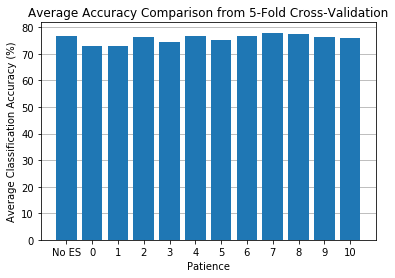

In [28]:
accuracies = []
labels = []
for patience, value in results.items():
    accuracies.append(value["avg_acc"])
    if patience == "-1":
        labels.append("No ES")
    else:
        labels.append(patience)
    
plt.bar(range(len(labels)), np.array(accuracies)*100, zorder=3)
plt.xticks(range(len(labels)), labels)
plt.xlabel("Patience")
plt.ylabel("Average Classification Accuracy (%)")
plt.title("Average Accuracy Comparison from 5-Fold Cross-Validation")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS:
    plt.savefig(RESULTS_PATH + "average_accuracy_comparison.pdf", format='pdf')
plt.show()

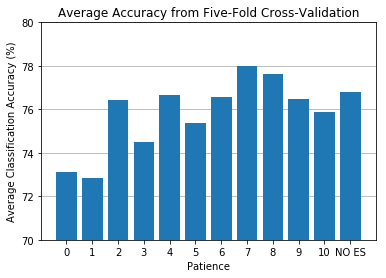

In [11]:
accuracies = []
labels = []
for patience, value in results.items():
    if patience != "-1":
        accuracies.append(value["avg_acc"])
        labels.append(patience)
        
labels.append("NO ES")
accuracies.append(results["-1"]["avg_acc"])
    
plt.bar(range(len(labels)), np.array(accuracies)*100, zorder=3)
plt.xticks(range(len(labels)), labels)
plt.xlabel("Patience")
plt.ylabel("Average Classification Accuracy (%)")
plt.title("Average Accuracy from Five-Fold Cross-Validation")
plt.ylim(70, 80)
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS:
    plt.savefig(RESULTS_PATH + "average_accuracy_comparison_zoomed.pdf", format='pdf')
plt.show()

### Average Loss

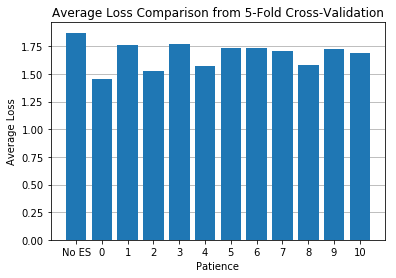

In [22]:
loss = []
labels = []
for patience, value in results.items():
    loss.append(value["avg_loss"])
    if patience == "-1":
        labels.append("No ES")
    else:
        labels.append(patience)
    
plt.bar(range(len(labels)), loss, zorder=3)
plt.xticks(range(len(labels)), labels)
plt.xlabel("Patience")
plt.ylabel("Average Loss")
plt.title("Average Loss Comparison from 5-Fold Cross-Validation")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS:
    plt.savefig(RESULTS_PATH + "average_loss_comparison.pdf", format='pdf')
plt.show()

### Average Epoch Stopped At

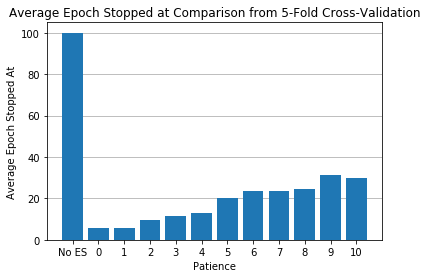

In [23]:
stopped = []
labels = []
for patience, value in results.items():
    stopped.append(value["avg_epoch_stopped"])
    if patience == "-1":
        labels.append("No ES")
    else:
        labels.append(patience)
    
plt.bar(range(len(labels)), stopped, zorder=3)
plt.xticks(range(len(labels)), labels)
plt.xlabel("Patience")
plt.ylabel("Average Epoch Stopped At")
plt.title("Average Epoch Stopped at Comparison from 5-Fold Cross-Validation")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS:
    plt.savefig(RESULTS_PATH + "average_stopped_epoch_comparison.pdf", format='pdf')
plt.show()

### Box Plot Comparison

In [15]:
seperated_results = {}
for patience, value in results.items():
    accuracies = []
    for user_label, res in value.items():
        if len(user_label) > 1:
            continue
        accuracies.append(res["accuracy"] * 100)
        
    if patience == "-1":
        seperated_results["No ES"] = accuracies

    else:
        seperated_results[patience] = accuracies

labels = []
for patience in early_stopping_patience:
    if patience == -1:
        labels.append("No ES")
    else:
        labels.append(str(patience))
data_to_plot = []
for label in labels:
    data_to_plot.append(seperated_results[label])

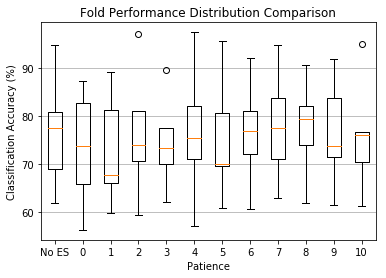

In [25]:
plt.boxplot(data_to_plot, labels=labels, zorder=3)
plt.title("Fold Performance Distribution Comparison")
plt.xlabel("Patience")
plt.ylabel("Classification Accuracy (%)")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS:
     plt.savefig(RESULTS_PATH + "boxplot.pdf", format='pdf')

In [16]:
ignore = ["0", "1", "2", "3", "4", "5", "6", "9", "10"]

In [21]:
seperated_results = {}
for patience, value in results.items():
    accuracies = []
    for user_label, res in value.items():
        if len(user_label) > 1:
            continue
        accuracies.append(res["accuracy"] * 100)
        
    if patience in ignore:
        continue
        
    if patience == "-1":
        seperated_results["No ES"] = accuracies

    else:
        seperated_results[patience] = accuracies

labels = []
for patience in early_stopping_patience:
    if patience != -1:
        labels.append(str(patience))
        
labels.append("No ES")

data_to_plot = []
new_labels = []
for label in labels:
    if label in ignore:
        continue
    data_to_plot.append(seperated_results[label])
    new_labels.append(label)

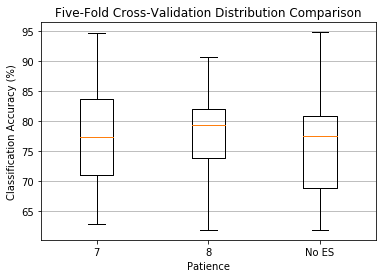

In [23]:
plt.boxplot(data_to_plot, labels=new_labels, zorder=3)
plt.title("Five-Fold Cross-Validation Distribution Comparison")
plt.xlabel("Patience")
plt.ylabel("Classification Accuracy (%)")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS:
     plt.savefig(RESULTS_PATH + "boxplot_zoomed.pdf", format='pdf')

Patience of 7 chosen for final model evaluation